In [1]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
import pandas as pd
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
import joblib


train_df = pd.read_csv('/content/gdrive/MyDrive/Dravidian_sentiment_analysis/Tam-SA-train.csv')
val_df = pd.read_csv('/content/gdrive/MyDrive/Dravidian_sentiment_analysis/Tam-SA-val.csv')

def clean_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    return text


train_df['Cleaned_Text'] = train_df['Text'].apply(clean_text)
val_df['Cleaned_Text'] = val_df['Text'].apply(clean_text)


label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['Label'])
y_val = label_encoder.transform(val_df['Label'])


tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train = tfidf_vectorizer.fit_transform(train_df['Cleaned_Text'])
X_val = tfidf_vectorizer.transform(val_df['Cleaned_Text'])


logreg_model = LogisticRegression(solver='liblinear')


param_grid = {'C': [0.1, 1, 10, 100]}
grid_search = GridSearchCV(logreg_model, param_grid, cv=3, verbose=1)
grid_search.fit(X_train, y_train)


best_logreg_model = grid_search.best_estimator_


print("\nEvaluating on training data:")
train_pred = best_logreg_model.predict(X_train)
train_accuracy = (train_pred == y_train).mean()
print(f"Training Accuracy: {train_accuracy:.4f}")

print("\nEvaluating on validation data:")
val_pred = best_logreg_model.predict(X_val)
val_accuracy = (val_pred == y_val).mean()
print(f"Validation Accuracy: {val_accuracy:.4f}")


print("\nTraining Classification Report:")
print(classification_report(y_train, train_pred, target_names=label_encoder.classes_))

print("\nValidation Classification Report:")
print(classification_report(y_val, val_pred, target_names=label_encoder.classes_))


joblib.dump(best_logreg_model, '/content/gdrive/MyDrive/Dravidian_sentiment_analysis/logreg_model.pkl')
joblib.dump(tfidf_vectorizer, '/content/gdrive/MyDrive/Dravidian_sentiment_analysis/logreg_tfidf_vectorizer.pkl')
joblib.dump(label_encoder, '/content/gdrive/MyDrive/Dravidian_sentiment_analysis/logreg_label_encoder.pkl')


Fitting 3 folds for each of 4 candidates, totalling 12 fits

Evaluating on training data:
Training Accuracy: 0.6850

Evaluating on validation data:
Validation Accuracy: 0.6386

Training Classification Report:
                precision    recall  f1-score   support

Mixed_feelings       0.63      0.16      0.25      3662
      Negative       0.63      0.38      0.48      4151
      Positive       0.70      0.94      0.80     18145
 unknown_state       0.64      0.39      0.48      5164

      accuracy                           0.69     31122
     macro avg       0.65      0.47      0.50     31122
  weighted avg       0.67      0.69      0.64     31122


Validation Classification Report:
                precision    recall  f1-score   support

Mixed_feelings       0.33      0.08      0.12       472
      Negative       0.52      0.29      0.38       480
      Positive       0.68      0.90      0.78      2272
 unknown_state       0.50      0.36      0.42       619

      accuracy         

['/content/gdrive/MyDrive/Dravidian_sentiment_analysis/logreg_label_encoder.pkl']

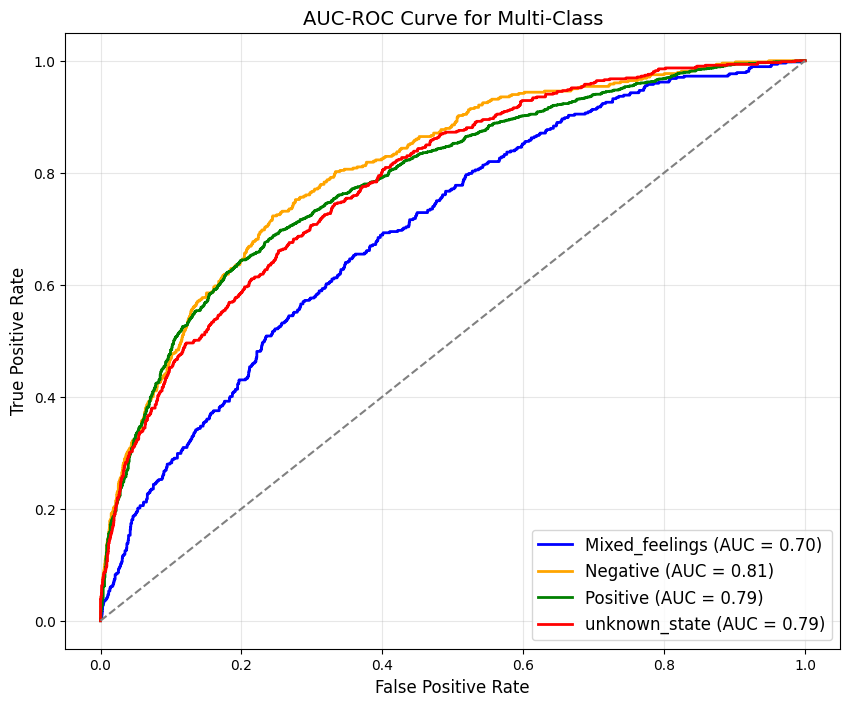

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize


y_train_binarized = label_binarize(y_train, classes=range(len(label_encoder.classes_)))
y_val_binarized = label_binarize(y_val, classes=range(len(label_encoder.classes_)))


val_probs = best_logreg_model.predict_proba(X_val)


colors = ['blue', 'orange', 'green', 'red']
plt.figure(figsize=(10, 8))


for i, (class_name, color) in enumerate(zip(label_encoder.classes_, colors)):
    val_fpr, val_tpr, _ = roc_curve(y_val_binarized[:, i], val_probs[:, i])
    val_auc = roc_auc_score(y_val_binarized[:, i], val_probs[:, i])

    plt.plot(val_fpr, val_tpr, color=color, label=f'{class_name} (AUC = {val_auc:.2f})', linewidth=2)

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')


plt.title("AUC-ROC Curve for Multi-Class", fontsize=14)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.show()


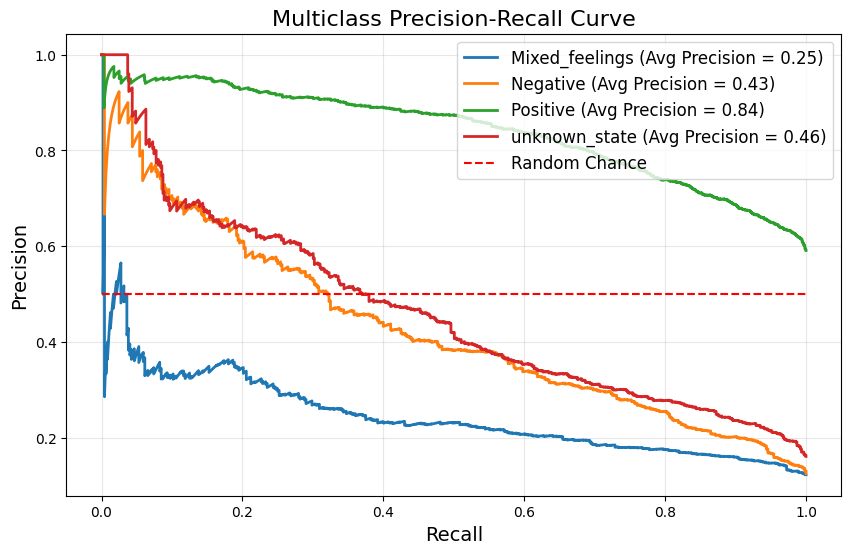

In [6]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt


n_classes = len(label_encoder.classes_)
colors = plt.cm.tab10.colors

plt.figure(figsize=(10, 6))

for i in range(n_classes):
    y_scores = best_logreg_model.predict_proba(X_val)[:, i]
    precision, recall, _ = precision_recall_curve(y_val == i, y_scores)
    avg_precision = average_precision_score(y_val == i, y_scores)

    plt.plot(recall, precision, color=colors[i], lw=2, label=f'{label_encoder.classes_[i]} (Avg Precision = {avg_precision:.2f})')


plt.plot([0, 1], [0.5, 0.5], linestyle='--', color='red', label='Random Chance')


plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.title("Multiclass Precision-Recall Curve", fontsize=16)
plt.legend(loc='upper right', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

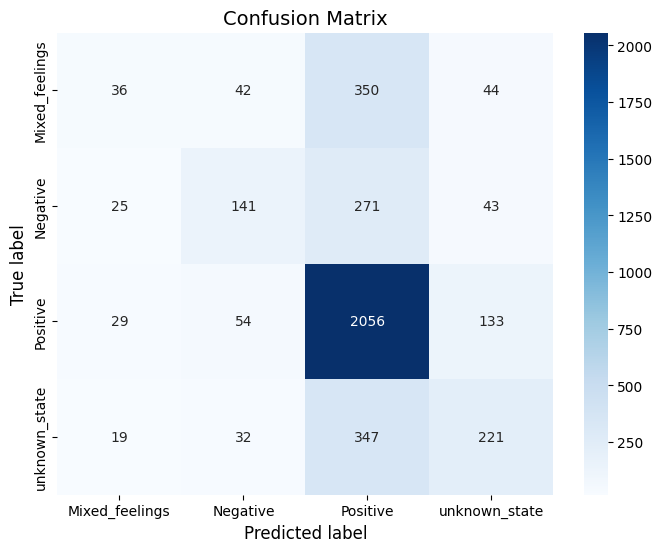

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


y_pred = best_logreg_model.predict(X_val)

cm = confusion_matrix(y_val, y_pred)

class_names = label_encoder.classes_

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)

plt.xlabel("Predicted label", fontsize=12)
plt.ylabel("True label", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.show()
